In [1]:
'''
Learn to scale magnitude of output
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings
import importlib

warnings.filterwarnings("ignore")

#Set random seeds for reproducibility of results 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

# import backbone model, dataset, and code utils
from models import Neural_Network, Neural_Network_Magnitude_Scaling
from constants import *
from utils import *
import analysis_utils
from data import *

Available device: cpu
Available device: cpu


In [2]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

In [25]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''
re_run = True
num_epochs = 10000

if re_run: 

    #Instantiate the model network
    model = Neural_Network_Magnitude_Scaling()
    # move to the current device (GPU or CPU)
    # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
    model.to(device)

    N = 3 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
    K = 10 # number of samples to draw from the task

    #Used to store the validation losses
    metaLosses = []
    metaValLosses = []

    #Meta-optimizer for the outer loop
    meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

    #Inner optimizer, we were doing this by hand previously
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        # store loss over all tasks to then do a large meta-level update of initial params
        # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
        meta_loss = None

        waves = dataset.get_meta_train_batch(task_batch_size=T)

        #Loop through all of the tasks
        for i, T_i in enumerate(waves): 
            train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
            held_out_task_specific_loss = train_eval_info[0]
            if meta_loss is None: 
                meta_loss = held_out_task_specific_loss
            else:
                meta_loss += held_out_task_specific_loss

        meta_optimizer.zero_grad()
        meta_loss /= T
        meta_loss.backward()
        meta_optimizer.step()
        metaLosses.append(meta_loss.item())

        # validation 
        val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
        val_train_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
        val_loss = val_train_eval_info[0]
        metaValLosses.append(val_loss.item())

        if epoch % printing_step == 0:
            print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
            # saving model help from: 
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), "mag_scaled_model.pt")

Iter =  0  Current Loss 4.753830432891846  Val Loss:  8.786977767944336
Iter =  500  Current Loss 3.1433954096125984  Val Loss:  2.65203291745559
Iter =  1000  Current Loss 2.4691886980455  Val Loss:  2.2233944877663014
Iter =  1500  Current Loss 1.878881799388456  Val Loss:  1.6852475917022638
Iter =  2000  Current Loss 1.541154064547116  Val Loss:  1.3849245793972005
Iter =  2500  Current Loss 1.3284107852832931  Val Loss:  1.1897161571423105
Iter =  3000  Current Loss 1.1780137569357736  Val Loss:  1.0515337882807707
Iter =  3500  Current Loss 1.0677461639510601  Val Loss:  0.9492993386647478
Iter =  4000  Current Loss 0.9796312246299392  Val Loss:  0.8688328928777134
Iter =  4500  Current Loss 0.9069150196439265  Val Loss:  0.804037431613359
Iter =  5000  Current Loss 0.8448238225206449  Val Loss:  0.7470166743670137
Iter =  5500  Current Loss 0.7921768531942774  Val Loss:  0.7015732537620338
Iter =  6000  Current Loss 0.7461015310332768  Val Loss:  0.6633137366902832
Iter =  6500 

In [43]:
# torch.save(model.state_dict(), "mag_scaled_model.pt")

# help from: https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = Neural_Network_Magnitude_Scaling()
model.load_state_dict(torch.load("mag_scaled_model.pt"))
criterion = nn.MSELoss()

shape:  (100, 10)
Step: 0, Error: 3.038166769221425, Var: 5.861606693666815
Step: 1, Error: 0.4214288253989071, Var: 0.15579783974702768
Step: 5, Error: 0.027586281999829224, Var: 0.0029848967600314825


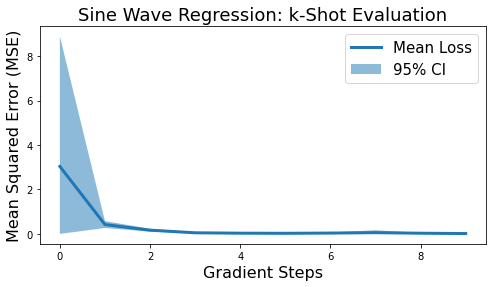

In [44]:
importlib.reload(analysis_utils)

num_k_shots = 10
K = 10
num_eval=100
file_tag = "magnitude_scaling_maml"

criterion = nn.MSELoss()
res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                        file_tag=file_tag)

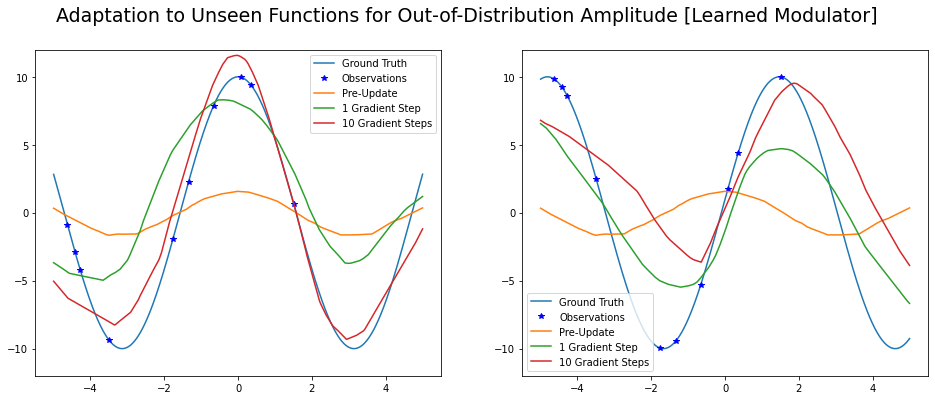

In [47]:
'''
Depict sample amplitude fitting for baseline model
Note, seeds are set for reproducibility
With seeds chosen quasi-randomly to ensure representative, yet compelling, examples for discussion of behavior
'''

importlib.reload(analysis_utils)

example_seed = 7

num_k_shots = 10
extract_task_info = True

K = 10

with_noise=False
noise_dev = 10

phases= [PI/2, 0.1]

ax_size=analysis_utils.ax_size
title_size=analysis_utils.title_size
dpi = analysis_utils.dpi

num_k_shots += 1


fig, axes = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Adaptation to Unseen Functions for Out-of-Distribution Amplitude [Learned Modulator]", fontsize=analysis_utils.title_size + 3)

for idx, phase in enumerate(phases): 

    ax = axes[idx]
    
    torch.manual_seed(example_seed)
    random.seed(example_seed)
    np.random.seed(example_seed)
    
    # ood amplitude, in-dist phase
    test_wave = SineFunction(amplitude = 10, phase = phase)


    # use model returned from earlier optimization
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
    held_out_task_specific_loss, metaTrainLosses, _, task_info = task_specific_train_and_eval(model, test_wave, 
                                                                                              inner_loop_optimizer,
                                                                                              criterion, K, 
                                                                                              num_k_shots, 
                                                                                              extract_task_info,
                                                                                             with_noise=with_noise,
                                                                                             noise_dev=noise_dev)

    true_vals = task_info["gt"]
    func_gt = task_info["gt_func"]
    func_prior = task_info["preds_0"]
    updated_func_single = task_info["preds_1"]
    updated_func_many = task_info[f"preds_{num_k_shots-1}"]

    ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="Ground Truth")
    ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="Observations", color="blue")
    ax.plot(np.array(func_prior)[:,0], np.array(func_prior)[:,1], label="Pre-Update")
    ax.plot(np.array(updated_func_single)[:,0], np.array(updated_func_single)[:,1], label="1 Gradient Step")
    ax.plot(np.array(updated_func_many)[:,0], np.array(updated_func_many)[:,1], label=f"{num_k_shots-1} Gradient Steps")

    ax.legend(fontsize=10)
    
    ax.set_ylim([-12,12])

plt.savefig(f"{analysis_utils.results_dir}amplitude_maml_modulation_scale.pdf",dpi=analysis_utils.dpi, bbox_inches="tight")

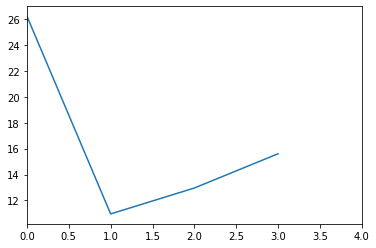

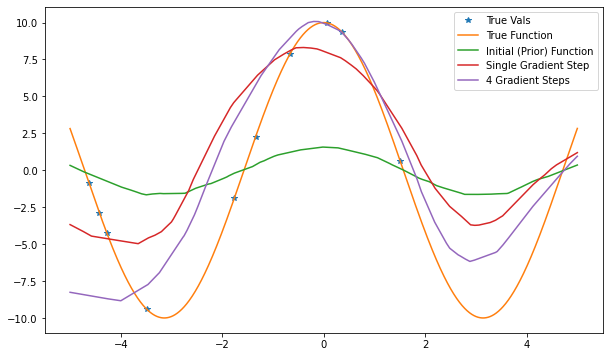

In [29]:
seed = 7

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

test_wave = SineFunction(amplitude = 10, phase = PI/2)

num_k_shots = 4
extract_task_info = True

K = 10

# test_wave = dataset.get_meta_test_batch(task_batch_size=1)[0]

with_noise=False
noise_dev = 10

inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)#lr_task_specific)

# use model returned from earlier optimization
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
held_out_task_specific_loss, metaTrainLosses, _, task_info = task_specific_train_and_eval(model, test_wave, 
                                                                                          inner_loop_optimizer,
                                                                                          criterion, K, 
                                                                                          num_k_shots, 
                                                                                          extract_task_info,
                                                                                         with_noise=with_noise,
                                                                                         noise_dev=noise_dev)

plt.plot(metaTrainLosses)
plt.xlim([0,num_k_shots])

fig, ax = plt.subplots(figsize=(10,6))
ax_size=16
title_size=18

true_vals = task_info["gt"]
func_gt = task_info["gt_func"]
func_prior = task_info["preds_0"]
updated_func_single = task_info["preds_1"]
updated_func_many = task_info[f"preds_{num_k_shots-1}"]

ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="True Vals")
ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="True Function")
ax.plot(np.array(func_prior)[:,0], np.array(func_prior)[:,1], label="Initial (Prior) Function")
ax.plot(np.array(updated_func_single)[:,0], np.array(updated_func_single)[:,1], label="Single Gradient Step")
ax.plot(np.array(updated_func_many)[:,0], np.array(updated_func_many)[:,1], label=f"{num_k_shots} Gradient Steps")

ax.legend()

In [34]:
'''
Boxplot for k-shot performance as a function of amplitude
Run k-shot eval for different amplitude and extract results
'''

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

test_amps = [5, 7, 10, 12]
num_k_shots = 3
num_k_shots += 1

k_labels = ["Pre-Update", "Single Gradient Step", f"{num_k_shots-1} Gradient Steps"]
k_idxs = [0, 1, num_k_shots-1]

num_eval = 100

# maintain ordered list of parameters and results
# for ease of creating data structure
amps = []
pre_update_res = []
single_update_res = []
many_update_res = []
mse_res = []
res_tags = []

for amp in test_amps: 
    all_losses = []
    
    # make waves which have the desired amplitude
    # randomly sample phase in range
    # looping to instantiate tasks idea from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
    # help on generating random numbers in range from: https://pynative.com/python-get-random-float-numbers/
    test_waves = [SineFunction(amplitude = amp, phase = random.uniform(phase_min, phase_max)) for _ in range(num_eval)]
    for test_eval in range(num_eval): 
        test_wave = test_waves[test_eval]

        # use model returned from earlier optimization
        inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
        held_out_task_specific_loss, metaTrainLosses, _, _ = task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, criterion, K=K, N=num_k_shots)

        all_losses.append(np.array(metaTrainLosses))

    all_losses = np.array(all_losses)
    
    # save for later dataframe
    for k, label in zip(k_idxs, k_labels): 
        amps.extend([amp for _ in range(num_eval)])
    
        mse_res.extend(all_losses[:, k])
    
        res_tags.extend([label for _ in range(num_eval)])

df = pd.DataFrame({"Amplitude": amps, "Mean Squared Error (MSE)": mse_res, "Evaluation Step": res_tags})

df.head(3)

,Amplitude,Mean Squared Error (MSE),Evaluation Step
0,5,9.301980,Pre-Update
1,5,12.660642,Pre-Update
2,5,8.479021,Pre-Update


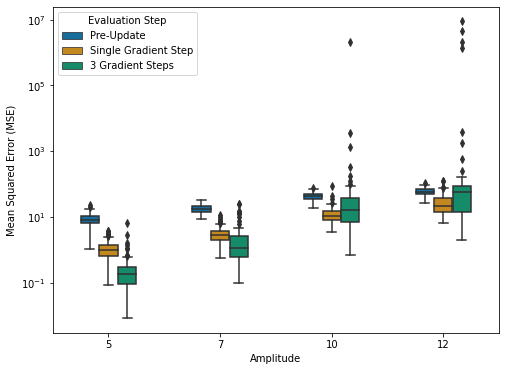

In [42]:
# boxplot help from: https://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/
show_df = df.loc[df.Amplitude != 20]
fig, ax = plt.subplots(figsize=(8,6))
res = sns.boxplot(y='Mean Squared Error (MSE)', x='Amplitude', 
                 data=show_df, 
                 width=0.5,
                    hue="Evaluation Step",
                 palette="colorblind")

# plt.ylim([0.0, 180.0])
ax.set_yscale('log') # log scale help from: https://stackoverflow.com/questions/773814/plot-logarithmic-axes-with-matplotlib-in-python